# Conditional Flow Matching

This notebook is a self-contained example of conditional flow matching. 

Related work on simulation free training of flow models includes:
* Flow Matching for Generative Modeling (Lipman et al. 2023) https://openreview.net/forum?id=PqvMRDCJT9t
* Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow (Liu et al. 2023) https://openreview.net/forum?id=XVjTT1nw5z
* Building Normalizing Flows with Stochastic Interpolants (Albergo et al. 2023) https://openreview.net/forum?id=li7qeBbCR1t

Note that this Flow Matching is different from the GFlowNet Flow Matching losses. Here we specifically regress against continuous flows, rather than matching inflows and outflows.

In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import *

In [2]:
# Implement some helper functions


def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()


class MLP(torch.nn.Module):
    def __init__(self, dim, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, dim),
        )

    def forward(self, x):
        return self.net(x)


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def plot_trajectories(traj):
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Conditional Flow Matching

First we implement the basic conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$

5000: loss 7.807 time 19.73


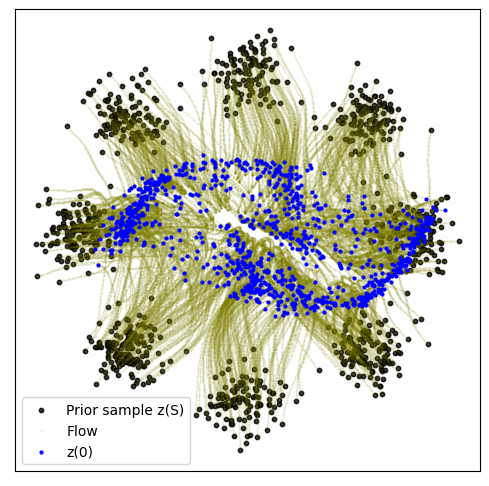

10000: loss 8.527 time 21.29


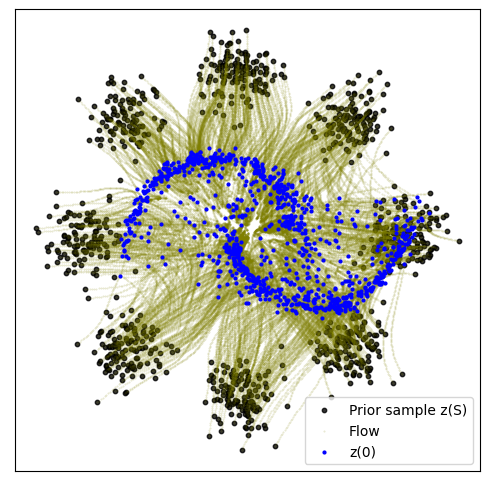

15000: loss 8.029 time 22.72


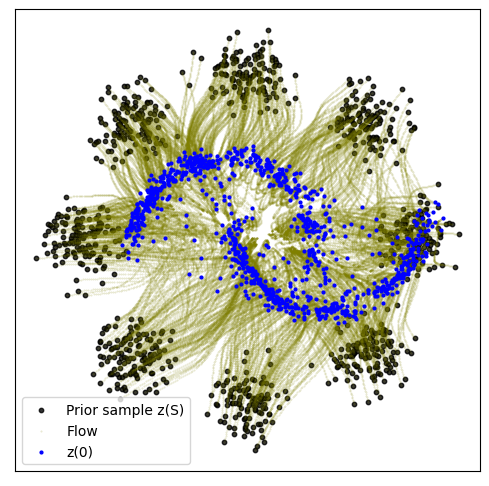

20000: loss 8.964 time 22.70


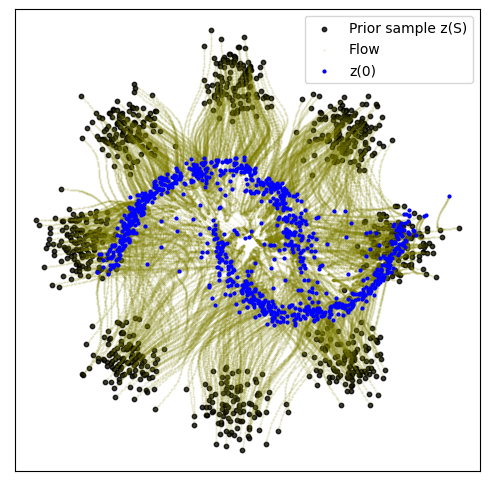

CPU times: user 1min 26s, sys: 320 ms, total: 1min 26s
Wall time: 1min 27s


In [3]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_moons(batch_size)
    x1 = sample_8gaussians(batch_size)
    mu_t = t * x1 + (1 - t) * x0
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(1, 0, 100),
            )
            plot_trajectories(traj)

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

5000: loss 0.231 time 57.35


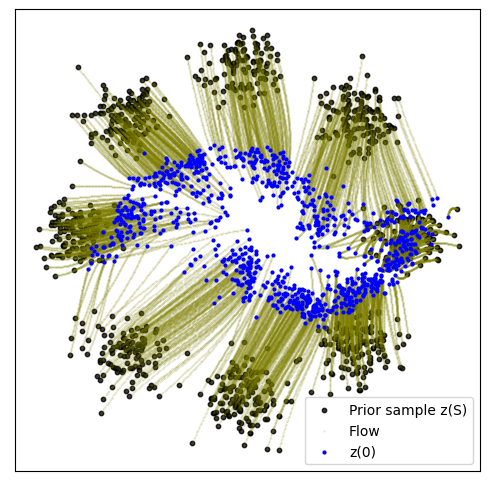

10000: loss 0.105 time 59.04


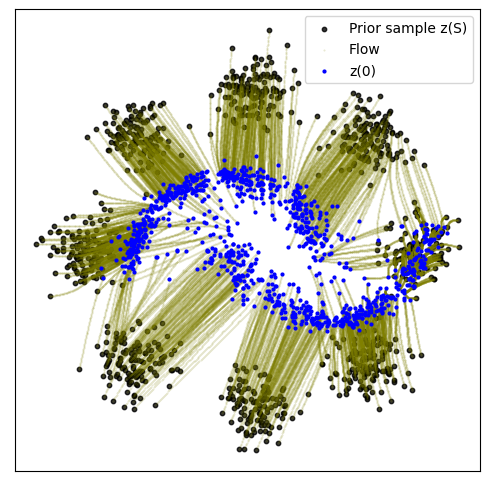

15000: loss 0.251 time 58.46


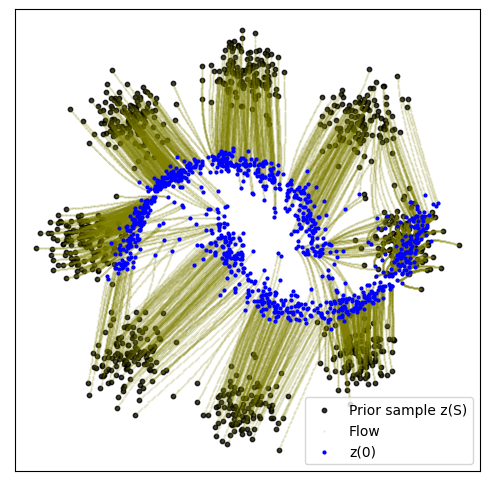

20000: loss 0.226 time 60.42


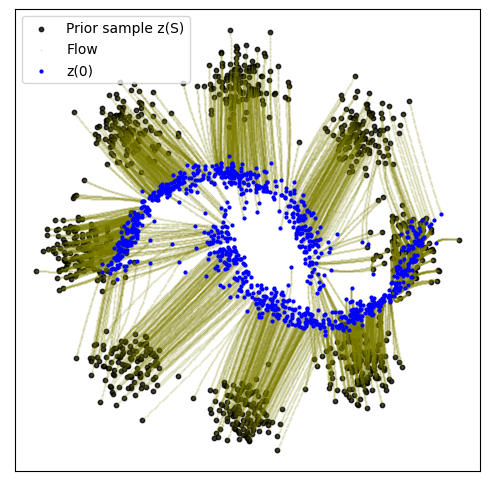

CPU times: user 3min 56s, sys: 347 ms, total: 3min 56s
Wall time: 3min 58s


In [4]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_moons(batch_size)
    x1 = sample_8gaussians(batch_size)

    # Resample x0, x1 according to transport matrix
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    pi = pot.emd(a, b, M.detach().cpu().numpy())
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    x0 = x0[i]
    x1 = x1[j]
    # calculate regression loss
    mu_t = x0 * (1 - t) + x1 * t
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(1, 0, 100),
            )
            plot_trajectories(traj)

### Schrödinger Bridge Conditional Flow Matching

Next we implement Schrödinger Bridge conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi_{2 \sigma^2} (x_0, x_1) \\
p_t(x | z) &= \mathcal{N}( x \mid t x_1 + (1 - t) x_0, t(1-t)\sigma^2)\\
u_t(x | z) &= \frac{1-2t}{2t(1-t)}(x - ( t x_1 + (1-t)x_0) ) + (x_1 - x_0)
\end{align}
$$
where $\pi_{2 \sigma^2}$ is the joint of a **Sinkhorn** optimal transport matrix with regularization $2 \sigma^2$. As in OT-CFM We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with the probability flow of a Schrödinger Bridge with reference measure $\sigma W$.

Note that the drift $v_\theta(t,x)$ we learn is *not* equivalent to the drift of the stochastic system, instead it is the drift of the equivalent probability flow ODE, however they are related through $p_t(x)$.

Also note that we use a larger $\sigma$ here both for convergence of the Sinkhorn algorithm and to make the differences more visible.

5000: loss 8.543 time 32.64


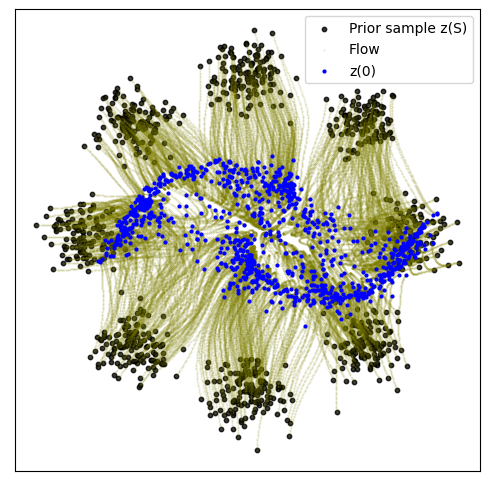

10000: loss 8.498 time 33.79


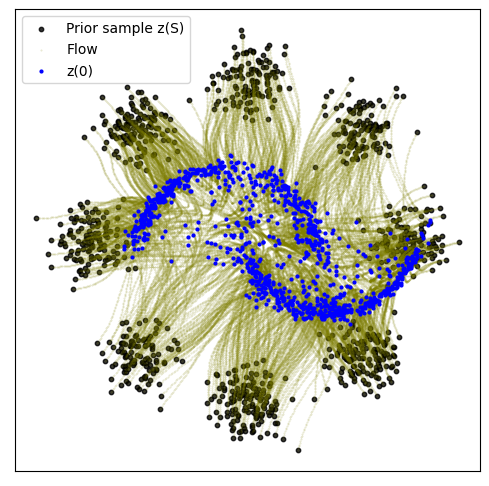

15000: loss 8.293 time 33.98


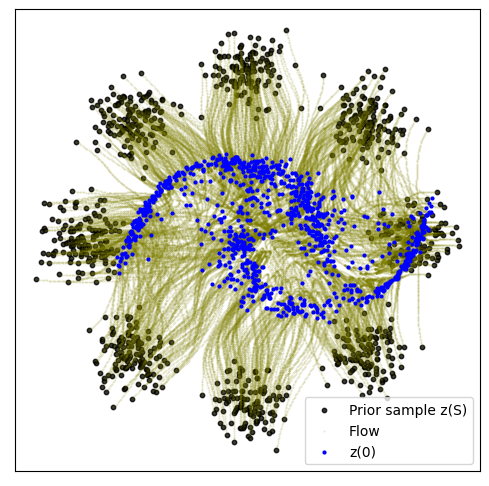

20000: loss 8.192 time 36.84


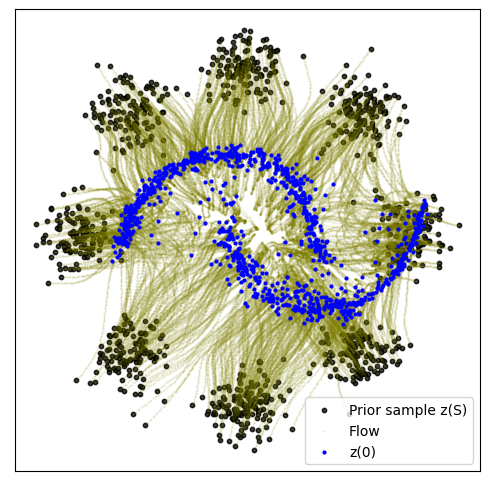

CPU times: user 2min 18s, sys: 339 ms, total: 2min 18s
Wall time: 2min 20s


In [5]:
%%time
sigma = 0.5
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_moons(batch_size)
    x1 = sample_8gaussians(batch_size)

    # Resample x0, x1 according to transport matrix
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=2 * (sigma**2))
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    x0 = x0[i]
    x1 = x1[j]
    # calculate regression loss
    mu_t = t * x1 + (1 - t) * x0
    sigma_t = sigma * torch.sqrt(t - t**2)
    x = mu_t + sigma_t * torch.randn_like(x0)
    sigma_t_prime_over_sigma_t = (1 - 2 * t) / (2 * t * (1 - t))
    ut = sigma_t_prime_over_sigma_t * (x - mu_t) + x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(1, 0, 100),
            )
            plot_trajectories(traj)